In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm 
from sklearn import decomposition
import time

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 07: Redução de dimensionalidade

**1.** Considere o conjunto de dados disponível em penguins.csv, organizado em 5
colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados
referem-se a medições anatômicas de pinguins da Antártida, classificados nas
espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem
ser conferidos em https://allisonhorst.github.io/palmerpenguins/.

**a)** Apresente a projeção em 2 dimensões dos padrões acima obtida pelo método PCA (análise dos componentes principais).

**b)** Ainda considerando o item anterior, calcule e mostre a variância explicada obtida quando a dimensão projetada é modificada (1,2,3 ou 4).

Normalize os dados antes de executar PCA. Implemente sua própria versão de PCA, mas verifique a corretude comparando contra alguma implementação popular (e.g., da biblioteca scikitlearn).

In [3]:
# Importando o dataset:
data = torch.from_numpy(pd.read_csv("./penguins.csv", header=None).to_numpy())

In [4]:
def PCA(X, n_components):
    """
    Implementação do PCA
    :param X: Input data
    :param n_components: Número de componentes principais 
    :return: Projeção dos dados, autovalores e autovetores
    """
    
    # Normalização dos dados
    X = (X - X.mean(dim=0)) / X.std(dim=0)
    
    # Cálculo da matriz de covariância
    C = torch.mm(X.T, X) / (X.shape[0] - 1)
    
    # Decomposição espectral
    eigvals, eigvecs = torch.linalg.eigh(C)
    
    # Ordenando os autovalores e autovetores
    idx = eigvals.argsort(descending=True)
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    
    # Projeção dos dados
    X_proj = torch.mm(X, eigvecs[:, :n_components])
    
    return X_proj, eigvals, eigvecs

In [5]:
X_proj, eigvals_proj, eigvecs_proj = PCA(data[:, :-1], 2)

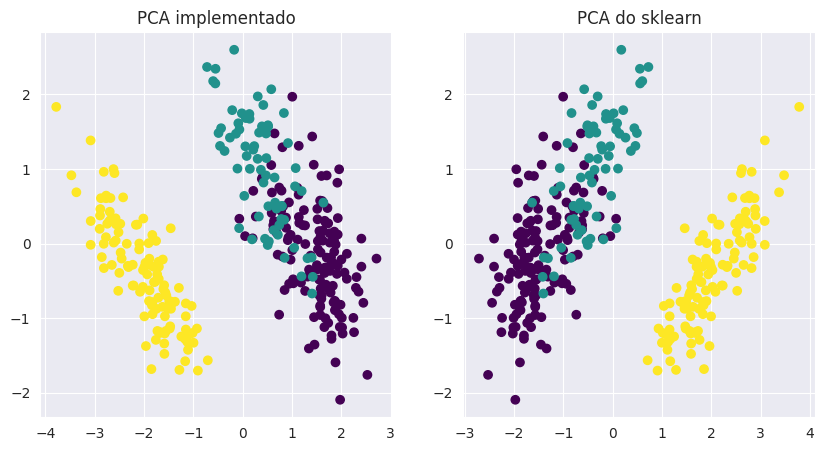

In [6]:
sklearn_pca = decomposition.PCA(n_components=2)

X = (data[:, :-1] - data[:, :-1].mean(dim=0)) / data[:, :-1].std(dim=0)
X_proj_sklearn = sklearn_pca.fit_transform(X.numpy())

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(X_proj[:, 0], X_proj[:, 1], c=data[:, -1], cmap='viridis')

ax[1].scatter(X_proj_sklearn[:, 0], X_proj_sklearn[:, 1], c=data[:, -1], cmap='viridis')

ax[0].set_title("PCA implementado")
ax[1].set_title("PCA do sklearn")
plt.show()

Como podemos ver, a projeção dos dados obtida pela implementação do PCA é idêntica à obtida pela implementação do sklearn, a não ser por uma inversão de sinal no eixo y. Isso ocorre porque a direção dos autovetores não é única, e a implementação do sklearn pode escolher a direção oposta à nossa.

In [12]:
# Show the explained variance for different number of components
explained_variance = [eigvals_proj[i-1] / torch.sum(eigvals_proj) for i in range(1, 5)]
sklearn_pca4 = decomposition.PCA(n_components=4)
sklearn_pca4.fit(X.numpy())
explained_variance_sklearn = [sklearn_pca4.explained_variance_ratio_[:i].sum() for i in range(1, 5)]
explained_variance, sklearn_pca4.explained_variance_ratio_

([tensor(0.6863, dtype=torch.float64),
  tensor(0.1945, dtype=torch.float64),
  tensor(0.0922, dtype=torch.float64),
  tensor(0.0270, dtype=torch.float64)],
 array([0.68633893, 0.19452929, 0.09216063, 0.02697115]))

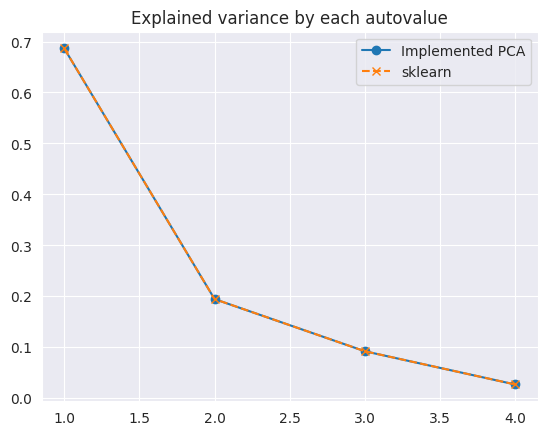

In [13]:
# Graph the explained variance by each autovalue
plt.plot(range(1,5),eigvals_proj/eigvals_proj.sum(), marker ='o', label='Implemented PCA')
plt.title("Explained variance by each autovalue")
# Graph the explained variance by each autovalue of the sklearn PCA
plt.plot(range(1,5),sklearn_pca4.explained_variance_ratio_, label="sklearn", marker='x', linestyle='--')
plt.legend()
plt.show()

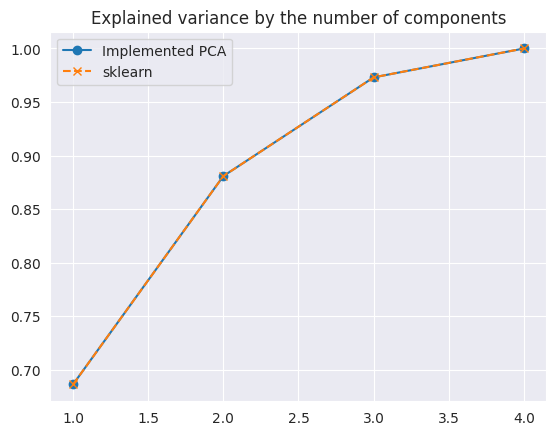

In [16]:
# Graph the explained variance by the number of components
plt.plot(range(1,5),[sum(eigvals_proj[:i]) / torch.sum(eigvals_proj) for i in range(1, 5)], marker ='o', label='Implemented PCA')
plt.title("Explained variance by the number of components")
# Graph the explained variance by the number of components of the sklearn PCA
plt.plot(range(1,5),explained_variance_sklearn, label="sklearn", marker='x', linestyle='--')
plt.legend()
plt.show()

**2.** Implemente um autoencoder determinísitco para o banco de dados MNIST, que já usamos em exercícios anteriores. Você pode escolher utilizar tanto CNN como MLP no encoder/decoder. No entanto, o encoder deve mapear as imagens no $\mathbb{R}^2$, para podermos visualizar as representações latentes no plano. Use o conjunto de validação para fazer early stopping. Você também pode monitorar o erro na validação para anelar a taxa de aprendizado (usando um scheduler). Finalmente, mostre a projeção das imagens de teste no espaço latente e comente qualitativamente os embeddings obtidos.

In [50]:
train_val_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

test_dataset, val_dataset = random_split(test_dataset, [5000, 5000])

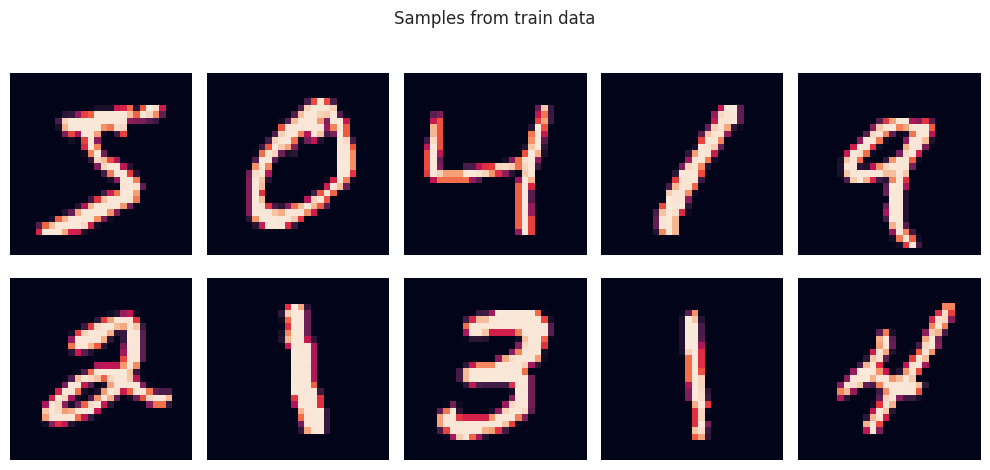

In [51]:
fig, ax = plt.subplots(2,5, figsize=(10,5))

for i in range(10):
    ax[i//5,i%5].imshow(train_val_dataset.data[i])
    ax[i//5,i%5].axis('off')
    
fig.suptitle("Samples from train data")
fig.tight_layout()

In [52]:
#batch_loader
batch_size = 64
train_loader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [53]:
def autoencoder_loss(x, x_hat):
    """
    Autoencoder loss function
    :param x: Input data
    :param x_hat: Reconstructed data
    :return: Loss value
    """
    return F.mse_loss(x_hat, x)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*32, 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 7*7*32),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    

In [54]:
# Training loop
device = torch.device("cpu")
print(f"Device: {device}")
model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
n_epochs = 100
best_val_loss = np.inf
early_stopping = 0

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for x, _ in tqdm.tqdm(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        x_hat = model(x)
        loss = autoencoder_loss(x, x_hat)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device)
            x_hat = model(x)
            loss = autoencoder_loss(x, x_hat)
            val_loss += loss.item()
        val_loss /= len(val_loader)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        early_stopping = 0
    else:
        early_stopping += 1
        if early_stopping == 10:
            break
    
    print(f"Epoch {epoch+1}/{n_epochs}: Train loss = {train_loss:.4f}, Val loss = {val_loss:.4f}")
    
model.load_state_dict(best_model)

/home/vinicius/.cache/pypoetry/virtualenvs/ml-crQxZaBn-py3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Device: cpu


100%|██████████| 938/938 [00:08<00:00, 110.19it/s]


Epoch 1/100: Train loss = 0.0669, Val loss = 0.0564


100%|██████████| 938/938 [00:07<00:00, 123.42it/s]


Epoch 2/100: Train loss = 0.0550, Val loss = 0.0534


100%|██████████| 938/938 [00:07<00:00, 123.47it/s]


Epoch 3/100: Train loss = 0.0529, Val loss = 0.0517


100%|██████████| 938/938 [00:07<00:00, 119.17it/s]


Epoch 4/100: Train loss = 0.0512, Val loss = 0.0504


100%|██████████| 938/938 [00:07<00:00, 122.56it/s]


Epoch 5/100: Train loss = 0.0499, Val loss = 0.0492


100%|██████████| 938/938 [00:07<00:00, 124.92it/s]


Epoch 6/100: Train loss = 0.0489, Val loss = 0.0484


100%|██████████| 938/938 [00:07<00:00, 124.33it/s]


Epoch 7/100: Train loss = 0.0482, Val loss = 0.0478


100%|██████████| 938/938 [00:07<00:00, 122.16it/s]


Epoch 8/100: Train loss = 0.0477, Val loss = 0.0475


100%|██████████| 938/938 [00:07<00:00, 125.76it/s]


Epoch 9/100: Train loss = 0.0473, Val loss = 0.0470


100%|██████████| 938/938 [00:07<00:00, 124.41it/s]


Epoch 10/100: Train loss = 0.0470, Val loss = 0.0469


100%|██████████| 938/938 [00:07<00:00, 123.76it/s]


Epoch 11/100: Train loss = 0.0466, Val loss = 0.0464


100%|██████████| 938/938 [00:07<00:00, 126.22it/s]


Epoch 12/100: Train loss = 0.0464, Val loss = 0.0462


100%|██████████| 938/938 [00:07<00:00, 127.31it/s]


Epoch 13/100: Train loss = 0.0461, Val loss = 0.0459


100%|██████████| 938/938 [00:07<00:00, 124.14it/s]


Epoch 14/100: Train loss = 0.0459, Val loss = 0.0458


100%|██████████| 938/938 [00:07<00:00, 125.22it/s]


Epoch 15/100: Train loss = 0.0456, Val loss = 0.0456


100%|██████████| 938/938 [00:07<00:00, 126.00it/s]


Epoch 16/100: Train loss = 0.0454, Val loss = 0.0454


100%|██████████| 938/938 [00:07<00:00, 121.33it/s]


Epoch 17/100: Train loss = 0.0452, Val loss = 0.0451


100%|██████████| 938/938 [00:07<00:00, 123.43it/s]


Epoch 18/100: Train loss = 0.0450, Val loss = 0.0449


100%|██████████| 938/938 [00:07<00:00, 123.49it/s]


Epoch 19/100: Train loss = 0.0448, Val loss = 0.0449


100%|██████████| 938/938 [00:07<00:00, 127.20it/s]


Epoch 20/100: Train loss = 0.0447, Val loss = 0.0447


100%|██████████| 938/938 [00:07<00:00, 124.95it/s]


Epoch 21/100: Train loss = 0.0445, Val loss = 0.0446


100%|██████████| 938/938 [00:07<00:00, 126.37it/s]


Epoch 22/100: Train loss = 0.0444, Val loss = 0.0448


100%|██████████| 938/938 [00:07<00:00, 123.35it/s]


Epoch 23/100: Train loss = 0.0443, Val loss = 0.0445


100%|██████████| 938/938 [00:07<00:00, 126.15it/s]


Epoch 24/100: Train loss = 0.0442, Val loss = 0.0446


100%|██████████| 938/938 [00:07<00:00, 125.17it/s]


Epoch 25/100: Train loss = 0.0441, Val loss = 0.0443


100%|██████████| 938/938 [00:07<00:00, 127.07it/s]


Epoch 26/100: Train loss = 0.0440, Val loss = 0.0441


100%|██████████| 938/938 [00:07<00:00, 122.24it/s]


Epoch 27/100: Train loss = 0.0439, Val loss = 0.0441


100%|██████████| 938/938 [00:07<00:00, 126.26it/s]


Epoch 28/100: Train loss = 0.0439, Val loss = 0.0441


100%|██████████| 938/938 [00:07<00:00, 125.72it/s]


Epoch 29/100: Train loss = 0.0438, Val loss = 0.0440


100%|██████████| 938/938 [00:07<00:00, 126.24it/s]


Epoch 30/100: Train loss = 0.0437, Val loss = 0.0440


100%|██████████| 938/938 [00:07<00:00, 125.01it/s]


Epoch 31/100: Train loss = 0.0436, Val loss = 0.0440


100%|██████████| 938/938 [00:07<00:00, 126.51it/s]


Epoch 32/100: Train loss = 0.0435, Val loss = 0.0437


100%|██████████| 938/938 [00:07<00:00, 124.32it/s]


Epoch 33/100: Train loss = 0.0435, Val loss = 0.0438


100%|██████████| 938/938 [00:07<00:00, 128.18it/s]


Epoch 34/100: Train loss = 0.0434, Val loss = 0.0437


100%|██████████| 938/938 [00:07<00:00, 126.34it/s]


Epoch 35/100: Train loss = 0.0434, Val loss = 0.0439


100%|██████████| 938/938 [00:07<00:00, 125.01it/s]


Epoch 36/100: Train loss = 0.0433, Val loss = 0.0437


100%|██████████| 938/938 [00:07<00:00, 126.51it/s]


Epoch 37/100: Train loss = 0.0433, Val loss = 0.0436


100%|██████████| 938/938 [00:07<00:00, 127.38it/s]


Epoch 38/100: Train loss = 0.0432, Val loss = 0.0435


100%|██████████| 938/938 [00:07<00:00, 126.33it/s]


Epoch 39/100: Train loss = 0.0432, Val loss = 0.0437


100%|██████████| 938/938 [00:08<00:00, 115.08it/s]


Epoch 40/100: Train loss = 0.0432, Val loss = 0.0434


100%|██████████| 938/938 [00:08<00:00, 115.86it/s]


Epoch 41/100: Train loss = 0.0431, Val loss = 0.0437


100%|██████████| 938/938 [00:07<00:00, 121.17it/s]


Epoch 42/100: Train loss = 0.0431, Val loss = 0.0433


100%|██████████| 938/938 [00:07<00:00, 123.44it/s]


Epoch 43/100: Train loss = 0.0431, Val loss = 0.0435


100%|██████████| 938/938 [00:07<00:00, 117.54it/s]


Epoch 44/100: Train loss = 0.0430, Val loss = 0.0434


100%|██████████| 938/938 [00:07<00:00, 121.15it/s]


Epoch 45/100: Train loss = 0.0430, Val loss = 0.0433


100%|██████████| 938/938 [00:07<00:00, 119.65it/s]


Epoch 46/100: Train loss = 0.0430, Val loss = 0.0434


100%|██████████| 938/938 [00:07<00:00, 120.81it/s]


Epoch 47/100: Train loss = 0.0429, Val loss = 0.0433


100%|██████████| 938/938 [00:07<00:00, 118.40it/s]


Epoch 48/100: Train loss = 0.0429, Val loss = 0.0433


100%|██████████| 938/938 [00:07<00:00, 119.54it/s]


Epoch 49/100: Train loss = 0.0429, Val loss = 0.0432


100%|██████████| 938/938 [00:07<00:00, 120.51it/s]


Epoch 50/100: Train loss = 0.0428, Val loss = 0.0432


100%|██████████| 938/938 [00:07<00:00, 122.50it/s]


Epoch 51/100: Train loss = 0.0428, Val loss = 0.0433


100%|██████████| 938/938 [00:07<00:00, 117.67it/s]


Epoch 52/100: Train loss = 0.0428, Val loss = 0.0432


100%|██████████| 938/938 [00:07<00:00, 118.95it/s]


Epoch 53/100: Train loss = 0.0428, Val loss = 0.0432


100%|██████████| 938/938 [00:07<00:00, 122.97it/s]


Epoch 54/100: Train loss = 0.0427, Val loss = 0.0431


100%|██████████| 938/938 [00:07<00:00, 123.22it/s]


Epoch 55/100: Train loss = 0.0427, Val loss = 0.0430


100%|██████████| 938/938 [00:07<00:00, 119.12it/s]


Epoch 56/100: Train loss = 0.0427, Val loss = 0.0432


100%|██████████| 938/938 [00:07<00:00, 118.34it/s]


Epoch 57/100: Train loss = 0.0427, Val loss = 0.0432


100%|██████████| 938/938 [00:07<00:00, 123.97it/s]


Epoch 58/100: Train loss = 0.0427, Val loss = 0.0432


100%|██████████| 938/938 [00:07<00:00, 121.32it/s]


Epoch 59/100: Train loss = 0.0426, Val loss = 0.0432


100%|██████████| 938/938 [00:07<00:00, 123.31it/s]


Epoch 60/100: Train loss = 0.0426, Val loss = 0.0431


100%|██████████| 938/938 [00:07<00:00, 121.34it/s]


Epoch 61/100: Train loss = 0.0426, Val loss = 0.0430


100%|██████████| 938/938 [00:07<00:00, 122.18it/s]


Epoch 62/100: Train loss = 0.0426, Val loss = 0.0429


100%|██████████| 938/938 [00:07<00:00, 124.23it/s]


Epoch 63/100: Train loss = 0.0426, Val loss = 0.0430


100%|██████████| 938/938 [00:07<00:00, 117.27it/s]


Epoch 64/100: Train loss = 0.0426, Val loss = 0.0431


100%|██████████| 938/938 [00:07<00:00, 121.59it/s]


Epoch 65/100: Train loss = 0.0425, Val loss = 0.0429


100%|██████████| 938/938 [00:07<00:00, 122.84it/s]


Epoch 66/100: Train loss = 0.0425, Val loss = 0.0428


100%|██████████| 938/938 [00:07<00:00, 125.27it/s]


Epoch 67/100: Train loss = 0.0425, Val loss = 0.0428


100%|██████████| 938/938 [00:07<00:00, 119.94it/s]


Epoch 68/100: Train loss = 0.0425, Val loss = 0.0429


100%|██████████| 938/938 [00:07<00:00, 121.57it/s]


Epoch 69/100: Train loss = 0.0425, Val loss = 0.0428


100%|██████████| 938/938 [00:07<00:00, 117.80it/s]


Epoch 70/100: Train loss = 0.0425, Val loss = 0.0428


100%|██████████| 938/938 [00:07<00:00, 120.65it/s]


Epoch 71/100: Train loss = 0.0425, Val loss = 0.0428


100%|██████████| 938/938 [00:07<00:00, 122.10it/s]


Epoch 72/100: Train loss = 0.0425, Val loss = 0.0428


100%|██████████| 938/938 [00:07<00:00, 119.94it/s]


Epoch 73/100: Train loss = 0.0424, Val loss = 0.0430


100%|██████████| 938/938 [00:08<00:00, 113.97it/s]


Epoch 74/100: Train loss = 0.0424, Val loss = 0.0427


100%|██████████| 938/938 [00:08<00:00, 115.74it/s]


Epoch 75/100: Train loss = 0.0424, Val loss = 0.0428


100%|██████████| 938/938 [00:07<00:00, 120.57it/s]


Epoch 76/100: Train loss = 0.0424, Val loss = 0.0427


100%|██████████| 938/938 [00:08<00:00, 116.62it/s]


Epoch 77/100: Train loss = 0.0424, Val loss = 0.0428


100%|██████████| 938/938 [00:07<00:00, 120.60it/s]


Epoch 78/100: Train loss = 0.0424, Val loss = 0.0429


100%|██████████| 938/938 [00:07<00:00, 121.29it/s]


Epoch 79/100: Train loss = 0.0423, Val loss = 0.0428


100%|██████████| 938/938 [00:07<00:00, 121.63it/s]


Epoch 80/100: Train loss = 0.0423, Val loss = 0.0429


100%|██████████| 938/938 [00:07<00:00, 119.91it/s]


Epoch 81/100: Train loss = 0.0423, Val loss = 0.0430


100%|██████████| 938/938 [00:07<00:00, 120.65it/s]


Epoch 82/100: Train loss = 0.0423, Val loss = 0.0427


100%|██████████| 938/938 [00:07<00:00, 120.24it/s]


Epoch 83/100: Train loss = 0.0418, Val loss = 0.0423


100%|██████████| 938/938 [00:07<00:00, 119.75it/s]


Epoch 84/100: Train loss = 0.0417, Val loss = 0.0423


100%|██████████| 938/938 [00:07<00:00, 120.91it/s]


Epoch 85/100: Train loss = 0.0417, Val loss = 0.0422


100%|██████████| 938/938 [00:07<00:00, 120.54it/s]


Epoch 86/100: Train loss = 0.0417, Val loss = 0.0422


100%|██████████| 938/938 [00:07<00:00, 122.72it/s]


Epoch 87/100: Train loss = 0.0417, Val loss = 0.0423


100%|██████████| 938/938 [00:07<00:00, 119.17it/s]


Epoch 88/100: Train loss = 0.0417, Val loss = 0.0422


100%|██████████| 938/938 [00:07<00:00, 120.77it/s]


Epoch 89/100: Train loss = 0.0417, Val loss = 0.0422


100%|██████████| 938/938 [00:07<00:00, 119.25it/s]


Epoch 90/100: Train loss = 0.0417, Val loss = 0.0422


100%|██████████| 938/938 [00:07<00:00, 121.99it/s]


Epoch 91/100: Train loss = 0.0416, Val loss = 0.0422


100%|██████████| 938/938 [00:07<00:00, 119.09it/s]


Epoch 92/100: Train loss = 0.0416, Val loss = 0.0422


100%|██████████| 938/938 [00:07<00:00, 123.27it/s]


Epoch 93/100: Train loss = 0.0416, Val loss = 0.0422


100%|██████████| 938/938 [00:08<00:00, 108.81it/s]


Epoch 94/100: Train loss = 0.0416, Val loss = 0.0422


100%|██████████| 938/938 [00:08<00:00, 106.99it/s]


Epoch 95/100: Train loss = 0.0416, Val loss = 0.0422


100%|██████████| 938/938 [00:08<00:00, 114.50it/s]


Epoch 96/100: Train loss = 0.0416, Val loss = 0.0423


100%|██████████| 938/938 [00:07<00:00, 121.09it/s]


Epoch 97/100: Train loss = 0.0416, Val loss = 0.0422


100%|██████████| 938/938 [00:07<00:00, 123.21it/s]


Epoch 98/100: Train loss = 0.0416, Val loss = 0.0422


100%|██████████| 938/938 [00:07<00:00, 122.85it/s]


Epoch 99/100: Train loss = 0.0416, Val loss = 0.0422


100%|██████████| 938/938 [00:07<00:00, 121.19it/s]


Epoch 100/100: Train loss = 0.0416, Val loss = 0.0422


<All keys matched successfully>

In [55]:
# Test the model
model.eval()
embeddings = []
outputs = []
inputs = []
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        inputs.append(x)
        z = model.encode(x)
        x_hat = model.decode(z)
        embeddings.append(z)
        outputs.append(x_hat)
        
embeddings = torch.cat(embeddings)
outputs = torch.cat(outputs)

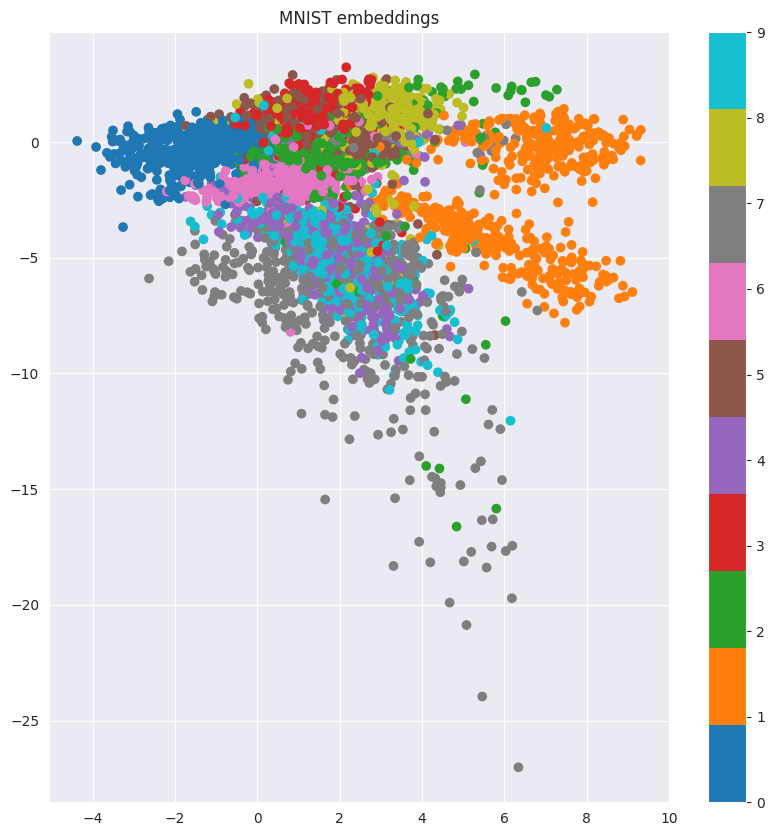

In [56]:
# Plot the embeddings
plt.figure(figsize=(10,10))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=test_dataset.dataset.targets[test_dataset.indices], cmap='tab10')
plt.colorbar()
plt.title("MNIST embeddings")
plt.show()

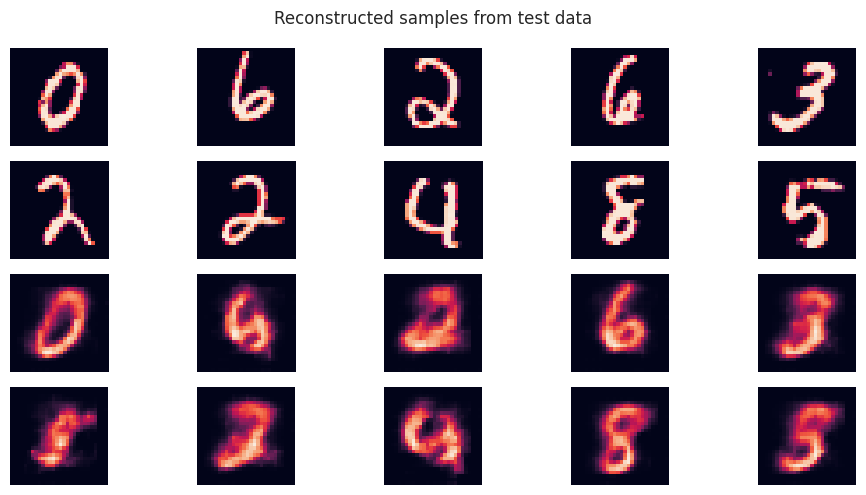

In [58]:
# Plot the reconstructions

fig, ax = plt.subplots(4,5, figsize=(10,5))

for i in range(10):
    ax[i//5,i%5].imshow(inputs[0][i].cpu().numpy().squeeze())
    ax[i//5,i%5].axis('off')
    ax[2+i//5,i%5].imshow(outputs[i].cpu().numpy().squeeze())
    ax[2+i//5,i%5].axis('off')
    
fig.suptitle("Reconstructed samples from test data")
fig.tight_layout()

Os embeddings obtidos pelo autoencoder são bastante interessantes. Podemos ver que os dígitos estão agrupados de acordo com suas classes. Isso mostra que o autoencoder foi capaz de aprender uma representação latente dos dados que preserva a informação necessária para reconstruir as imagens originais. Além disso, podemos ver que temos sobreposiçao entre várias classes, como podemos ver nas imagens reconstruídas, onde tivemos um 2 ser reconstruído como um 5, por exemplo. 
Outro fenômeno interessante é que o digito 1 está agrupado em 2 grupos distintos, o que pode ser explicado pela variação na forma como o dígito 1 é escrito. 
O número 7 não está bem agrupado, se dispersando num espaço maior.